In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# --- HYPERPARAMETERS ---
# DATA PARAMETERS
IMAGE_SIZE = 72       # The input image size (e.g., 72x72 pixels)
NUM_CHANNELS = 10     # Number of satellite image bands (e.g., Sentinel-2)
PATCH_SIZE = 6        # The size of each patch (must divide IMAGE_SIZE evenly)

# MODEL PARAMETERS
PROJECTION_DIM = 64   # The dimension of the patch embeddings
NUM_HEADS = 4         # Number of attention heads
TRANSFORMER_LAYERS = 8 # Number of transformer blocks
TRANSFORMER_UNITS = [PROJECTION_DIM * 2, PROJECTION_DIM] # MLP hidden layer sizes
MLP_HEAD_UNITS = [256, 128] # Dense layers for the final prediction head

In [2]:
class Patches(layers.Layer):
    """Takes an image and converts it into patches."""
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # Reshape to (batch_size, num_patches, patch_dim)
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [42]:
class PatchEncoder(layers.Layer):
    """Projects patches and adds learnable positional embedding."""
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        # Linear projection layer
        self.projection = layers.Dense(units=projection_dim)
        # Learnable positional embeddings
        self.position_embedding = layers.Embedding(
            input_dim=num_patches + 1, output_dim=projection_dim
        )
        # Learnable CLS token
        self.cls_token = tf.Variable(tf.random.normal([1, 1, projection_dim]), trainable=True)

    def call(self, patch):
        batch_size = tf.shape(patch)[0]
        
        # --- FIX IS HERE ---
        # 1. First, project the patches to the target dimension.
        projected_patches = self.projection(patch)
        
        # 2. Get the shape for broadcasting the CLS token.
        #    The last dimension is now projection_dim, which matches the CLS token.
        _, _, projection_dim = projected_patches.shape
        
        # 3. Create positions for both CLS and all patches.
        positions = tf.range(start=0, limit=self.num_patches + 1, delta=1)
        
        # 4. Broadcast the CLS token to match the batch size.
        cls_broadcasted = tf.cast(
            tf.broadcast_to(self.cls_token, [batch_size, 1, projection_dim]),
            dtype=projected_patches.dtype,
        )
        
        # 5. Concatenate the CLS token with the *projected* patches.
        encoded = tf.concat([cls_broadcasted, projected_patches], axis=1)
        
        # 6. Add the positional embeddings.
        encoded += self.position_embedding(positions)
        
        return encoded

In [7]:
def create_vit_regressor():
    # --- Input Layer ---
    inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
    
    # --- Create Patches ---
    patches = Patches(PATCH_SIZE)(inputs)
    num_patches = (IMAGE_SIZE // PATCH_SIZE) ** 2
    
    # --- Encode Patches ---
    encoded_patches = PatchEncoder(num_patches, PROJECTION_DIM)(patches)
    
    # --- Transformer Encoder Blocks ---
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Multi-Head Attention
        attention_output = layers.MultiHeadAttention(
            num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
        )(x1, x1)
        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])
        
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        for units in TRANSFORMER_UNITS:
            x3 = layers.Dense(units, activation=tf.nn.gelu)(x3)
        
        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])
        
    # --- Final Prediction Head ---
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    # Extract the CLS token's output which has aggregated the sequence info
    cls_output = representation[:, 0]
    
    # Add a final MLP head for regression
    x = cls_output
    for units in MLP_HEAD_UNITS:
        x = layers.Dense(units, activation='relu')(x)
    
    # The final output neuron for regression (linear activation)
    outputs = layers.Dense(1, activation='linear')(x)
    
    # --- Create Keras Model ---
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [8]:
# Build the model
vit_regressor = create_vit_regressor()

# Compile the model for a regression task
vit_regressor.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.MeanSquaredError(), # Use Mean Squared Error for regression
    metrics=[keras.metrics.RootMeanSquaredError()]
)

# Print the model summary
vit_regressor.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 72, 72,    │          0 │ -                 │
│ (InputLayer)        │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches_1 (Patches) │ (None, None, 360) │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder_1     │ (None, 145, 64)   │     32,384 │ patches_1[0][0]   │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 145, 64)   │        128 │ patch_encoder_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 145, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 145, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 145, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 145, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 145, 64)   │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 145, 64)   │          0 │ dense_3[0][0],    │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 145, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 145, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 145, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 145, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 145, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 145, 64)   │      8,256 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 145, 64)   │          0 │ dense_5[0][0],    │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 145, 64)   │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 747,777 (2.85 MB)

 Trainable params: 747,777 (2.85 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os

# --- HYPERPARAMETERS ---
# These should match the parameters used when you defined your model
IMAGE_SIZE = 72       # The input image size (e.g., 72x72 pixels)
NUM_CHANNELS = 10     # Number of satellite image bands
BATCH_SIZE = 16       # Number of samples per batch

In [11]:
# --- This part creates a fake dataset so the example can run ---

# Create a directory for our dummy images
if not os.path.exists("satellite_data"):
    os.makedirs("satellite_data")

# Create a list to hold our data for the CSV
dummy_data_for_csv = []
print("Creating dummy satellite images and labels.csv...")
for i in range(100):
    # Create a fake multi-channel image (as a .npy file)
    file_name = f"satellite_data/tile_{i:03d}.npy"
    # The shape is (height, width, channels)
    dummy_image = np.random.rand(IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS).astype("float32")
    np.save(file_name, dummy_image)
    
    # Generate a random pH value for this image
    dummy_ph = np.random.uniform(4.0, 9.0)
    dummy_data_for_csv.append([file_name, dummy_ph])

# Create a pandas DataFrame and save it as a CSV file
labels_df = pd.DataFrame(dummy_data_for_csv, columns=["image_path", "ph"])
labels_df.to_csv("labels.csv", index=False)
print("Dummy data created successfully.")

Creating dummy satellite images and labels.csv...
Dummy data created successfully.


In [12]:
# Load your dataset's metadata from the CSV file
data = pd.read_csv("labels.csv")
image_paths = data["image_path"].values
labels = data["ph"].values.astype(np.float32)

print(f"Loaded {len(image_paths)} image paths and labels.")

Loaded 100 image paths and labels.


In [15]:
def parse_image(image_path, label):
    # This function will be wrapped by tf.py_function, so it can run Python code
    def load_and_preprocess(path):
        # --- FIX IS HERE ---
        # Decode the byte string path by first converting the Tensor to a NumPy object
        path = path.numpy().decode()
        
        # --- IMPORTANT: CHOOSE YOUR FILE TYPE ---
        # If you are using .npy files, use np.load
        image = np.load(path)
        
        # If you are using real GeoTIFF files, you would use a library like rasterio
        # import rasterio
        # with rasterio.open(path) as src:
        #     # Example: read the first 10 bands and transpose to (H, W, C)
        #     image = np.transpose(src.read(range(1, 11)), (1, 2, 0))
            
        return image.astype(np.float32)

    # Use tf.py_function to run the custom loading logic
    image = tf.py_function(load_and_preprocess, [image_path], tf.float32)
    
    # The py_function loses shape information, so we must set it back manually
    image.set_shape([IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS])
    
    return image, label

In [16]:
# An AUTOTUNE setting for optimal performance
AUTOTUNE = tf.data.AUTOTUNE

# 1. Create a TensorFlow Dataset from the file paths and labels
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

# 2. Map the parsing function to each element, parallelizing the data loading
dataset = dataset.map(parse_image, num_parallel_calls=AUTOTUNE)

# 3. Shuffle the data for better training randomness
dataset = dataset.shuffle(buffer_size=len(image_paths))

# 4. Batch the data into groups of BATCH_SIZE
dataset = dataset.batch(BATCH_SIZE)

# 5. Prefetch the next batch while the current one is being processed on the GPU
train_dataset = dataset.prefetch(buffer_size=AUTOTUNE)

print("TensorFlow data pipeline created successfully.")

# --- Inspect a single batch from your new pipeline ---
for images, labels in train_dataset.take(1):
    print(f"\nShape of a single image batch: {images.shape}")
    print(f"Shape of a single label batch: {labels.shape}")

TensorFlow data pipeline created successfully.

Shape of a single image batch: (16, 72, 72, 10)
Shape of a single label batch: (16,)


2025-09-25 19:53:55.371069: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [34]:
history = vit_regressor.fit(
    train_dataset,
    epochs=15
)

Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - loss: 2.2268 - root_mean_squared_error: 1.4922
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - loss: 2.2423 - root_mean_squared_error: 1.4974
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - loss: 2.2394 - root_mean_squared_error: 1.4965
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - loss: 2.2266 - root_mean_squared_error: 1.4922
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - loss: 2.2292 - root_mean_squared_error: 1.4931
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - loss: 2.2279 - root_mean_squared_error: 1.4926
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - loss: 2.2260 - root_mean_squared_error: 1.4920
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - loss: 2.2394 - root_mean_squared_error: 1.4965
Epoch 9/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 2.2382 - root_mean_squared_error: 1.4961
Epoch 10/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 294ms/step - loss: 2.2151 - root_mean_squared_error: 1.4883
Epoch 11/

In [21]:
# --- You would do this after loading your data ---
from sklearn.model_selection import train_test_split
# X_train_paths, X_test_paths, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2)
# Then create a train_dataset and a separate test_dataset pipeline

# For now, let's create a dummy test set to demonstrate
X_test = np.random.rand(20, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS).astype("float32")
y_test = np.random.uniform(4.0, 9.0, (20, 1)).astype("float32")

# --- Evaluate the model ---
print("\n--- Evaluating Model on Test Data ---")
results = vit_regressor.evaluate(X_test, y_test, batch_size=16)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Root Mean Squared Error (RMSE): {results[1]:.4f}")


--- Evaluating Model on Test Data ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 2.1921 - root_mean_squared_error: 1.4806 
Test Loss: 2.1921
Test Root Mean Squared Error (RMSE): 1.4806


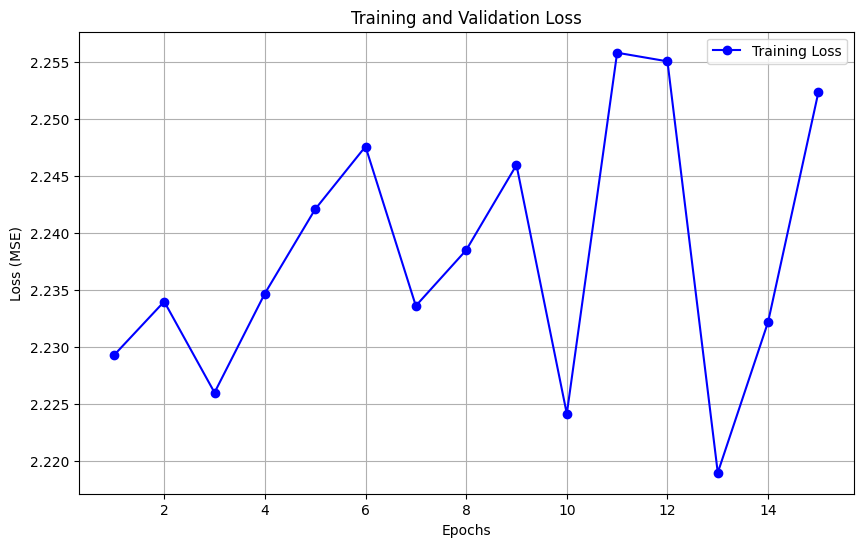

In [22]:
import matplotlib.pyplot as plt

# --- Plotting training & validation loss ---
loss = history.history['loss']
val_loss = history.history.get('val_loss') # Use .get() in case you didn't have a validation split

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
if val_loss:
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


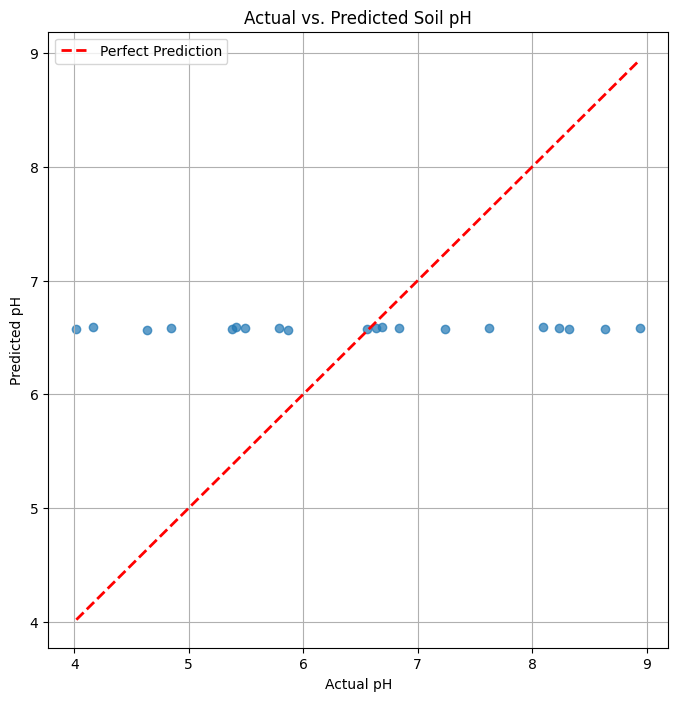

In [23]:
# --- Make predictions on the test set ---
predicted_ph = vit_regressor.predict(X_test)

# --- Create a scatter plot of actual vs. predicted values ---
plt.figure(figsize=(8, 8))
plt.scatter(y_test, predicted_ph, alpha=0.7)
plt.xlabel('Actual pH')
plt.ylabel('Predicted pH')
plt.title('Actual vs. Predicted Soil pH')
# Add a line for perfect correlation
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.grid(True)
plt.legend()
plt.show()

In [33]:
import os

file_to_find = "vit_soil_ph_regressor_from_scratch.keras"
found_path = None

# Search recursively starting from the current directory '.'
for root, dirs, files in os.walk('.'):
    if file_to_find in files:
        found_path = os.path.join(root, file_to_find)
        break # Stop searching once found

if found_path:
    print(f"✅ File found! Use this exact path:\n{found_path}")
else:
    print(f"❌ File not found in the current directory or its subfolders.")

❌ File not found in the current directory or its subfolders.


In [35]:
import os

# Define a specific directory to save your models
model_dir = "saved_models"
os.makedirs(model_dir, exist_ok=True) # Create the directory if it doesn't exist

# Define the full path for the model file
file_path = os.path.join(model_dir, "vit_soil_ph_regressor_from_scratch.keras")

# --- Save the Model ---
print(f"Saving model to: {file_path}")
vit_regressor.save(file_path)

# --- Verify the File Was Saved ---
if os.path.exists(file_path):
    print(f"\n✅ Success! Model was saved correctly at {file_path}")
else:
    print(f"\n❌ Error! Something went wrong and the model was not saved.")

Saving model to: saved_models/vit_soil_ph_regressor_from_scratch.keras

✅ Success! Model was saved correctly at saved_models/vit_soil_ph_regressor_from_scratch.keras


In [45]:
# Save the model in saved_models directory
vit_regressor.save("saved_models/vit_soil_ph_regressor_from_scratch.keras")